## STAT 7510 Final Project

Eric Wilson

Summer 2022

## Predicting Term Deposit Subscriptions 

### Objective

The objective of this project is to predict whether or not a client will subscribe to a term deposit with a bank based on outstanding loans and the frequency of marketing interactions with the bank. 

### Libraries 

In [1]:
install.packages(c("tree", "MASS", "randomForest","gbm", "ggplot2", "reshape2"))
library(tree)
library(MASS)
library(randomForest)
library(gbm)
library(ggplot2)
library(reshape2)
print("Complete")

Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/tree_1.0-42.tar.gz' ...
	OK [downloaded 171.3 Kb in 0.3 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/MASS_7.3-58.1.tar.gz' ...
	OK [downloaded 1.1 Mb in 0.2 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/randomForest_4.7-1.1.tar.gz' ...
	OK [downloaded 256.7 Kb in 0.3 secs]
Retrieving 'https://packagemanager.rstudio.com/all/__linux__/focal/latest/src/contrib/gbm_2.1.8.1.tar.gz' ...
	OK [downloaded 1.2 Mb in 0.2 secs]
Installing tree [1.0-42] ...
	OK [installed binary]
Moving tree [1.0-42] into the cache ...
	OK [moved to cache in 0.43 milliseconds]
Installing MASS [7.3-58.1] ...
	OK [installed binary]
Moving MASS [7.3-58.1] into the cache ...
	OK [moved to cache in 0.34 milliseconds]
Installing randomForest [4.7-1.1] ...
	OK [installed binary]
Moving randomForest [4.7-1.1] into the cache ...
	OK [moved to cache

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.

Loaded gbm 2.1.8.1


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin




[1] "Complete"


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.

Loaded gbm 2.1.8.1



randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.



randomForest 4.7-1.1



### Data

The data deals with the marketing campaigns of a Portuguese financial institution; this dataset was found on UCI's Machine Learning Repository (http://archive.ics.uci.edu/ml/datasets/Bank+Marketing). The particular dataset being used is the "bank-full.csv" dataset.

The target value is whether or not a client signed up for term deposit, which is a binary value (yes or no), meaning this is a problem to be solved with classification. 

In [2]:
bank <- read.delim("bank-full.csv", sep = ";")
### Changed target column name from y to subscribed, to be more descriptive
colnames(bank)[colnames(bank) == "y"] <- "subscribed"
bank$subscribed <- ifelse(bank$subscribed == "yes", 1, 0)
head(bank, 3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<dbl>
1,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
2,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
3,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0


### Variables to be Used

Feature variables to be used:

    1 - age: age of client
    
    6 - balance: average yearly balance, in euros (numeric) 
    
    7 - housing: has housing loan? (categorical: 'no','yes','unknown')

    8 - loan: has personal loan? (categorical: 'no','yes','unknown')
    
    14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
    
    15 - previous: number of contacts performed before this campaign and for this client (numeric)
    
    16 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

Target variable:

    17 - subscribed (initially "y"): has the client subscribed a term deposit? (binary: 'no', 'yes')
    
Several of the feature variables have three values, being "yes/success", "unknown/nonexistent", and "no/failure." In this model, we will group anything that is not a definitive "yes/success" as 0, whereas "yes/success" will be labeled as 1; essentially, if it is not a positive case, it will be treated as a failure.

In [3]:
# setting unknown and no/failure to 0
bank <- bank[, c(6, 7, 8, 14, 15, 16, 17)]
bank$housing <- ifelse(bank$housing == "yes", 1, 0)
bank$loan <- ifelse(bank$loan == "yes", 1, 0)
bank$poutcome <- ifelse(bank$poutcome == "success", 1, 0)
head(bank,3)

,balance,housing,loan,pdays,previous,poutcome,subscribed
,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>
1,2143,1,0,-1,0,0,0
2,29,1,0,-1,0,0,0
3,2,1,1,-1,0,0,0


,balance,housing,loan,pdays,previous,poutcome,subscribed
balance,1.000000000,-0.06876832,-0.08435025,0.003435322,0.01667364,0.03524034,0.05283841
housing,-0.068768316,1.00000000,0.04132287,0.124178400,0.03707615,-0.09136026,-0.13917270
loan,-0.084350246,0.04132287,1.00000000,-0.022753639,-0.01104349,-0.05371260,-0.06818503
pdays,0.003435322,0.12417840,-0.02275364,1.000000000,0.45481964,0.22853889,0.10362149
previous,0.016673637,0.03707615,-0.01104349,0.454819635,1.00000000,0.20142401,0.09323577
poutcome,0.035240342,-0.09136026,-0.05371260,0.228538887,0.20142401,1.00000000,0.30678821
subscribed,0.052838410,-0.13917270,-0.06818503,0.103621494,0.09323577,0.30678821,1.00000000


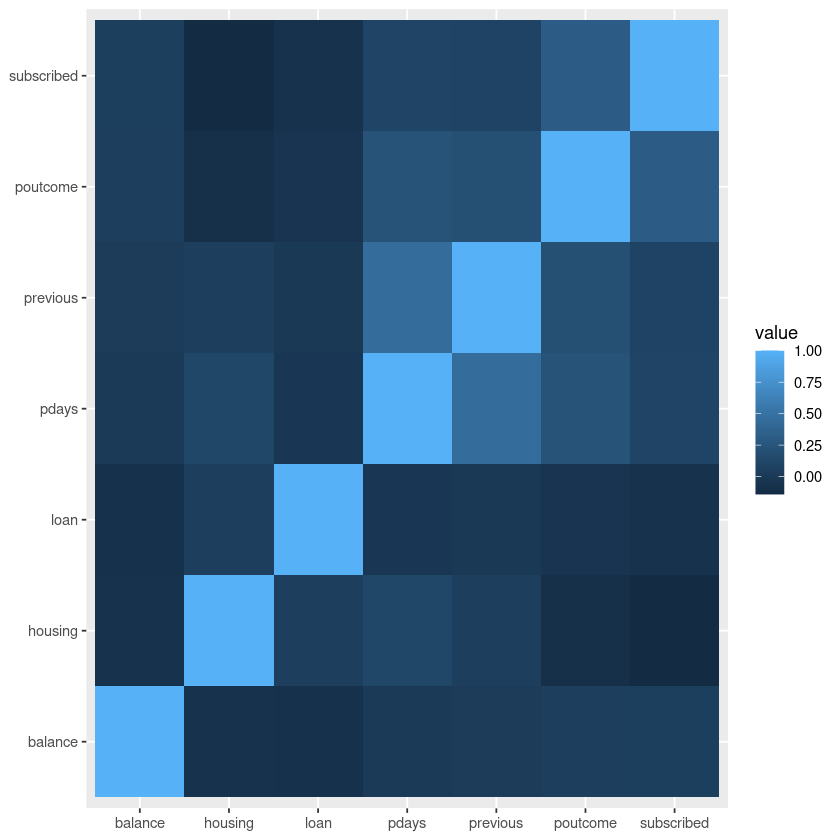

In [4]:
cor(bank)
cormat <- round(x = cor(bank), digits = 2)
melted_cormat <- melt(cormat)
ggplot(data = melted_cormat, aes(x=Var1, y=Var2, fill = value)) +
  geom_tile() +
    theme(axis.title.x=element_blank(),axis.title.y=element_blank())

The correlations which exist tend to be quite weak. Let's see if any models can do a relatively good job at predicting whether a customer subscribes to a term deposit, given these variables. 

### Train / Test Split

The data will be split into 80% training data and 20% test data. 

In [5]:
set.seed(1)
OBS <- sample(1:nrow(bank),.8*nrow(bank),replace=FALSE)
banktrain <- bank[OBS,]
banktest <- bank[-OBS,]

### Models

The models which will be used are Logistic Regression (GLM), Linear Discriminant Analysis (LDA), Quadratic Discriminant Analysis (QDA), and Decision Tree(s). Due to the prevalence of discrete variables (due to the yes, no, and unknown of several variables), KNN will not be used, as a preliminary attempt yielded too many ties.

In [6]:
K=5
cv.error <- matrix(NA,nrow=3,ncol=K)
set.seed(1)
folds <- sample(1:K,nrow(bank),replace=TRUE)
print("Complete")

[1] "Complete"


### GLM

In [7]:
glm.fit = glm(subscribed ~ ., data = banktrain, family = binomial, subset = OBS)
glm.probs <- predict(glm.fit, banktest, type = "response")
glm.pred <- rep(0, length(glm.probs))
glm.pred[glm.probs > .5] = 1
cm <- table (glm.pred, banktest$subscribed)
print("Confuision matrix table: ")
cm
print(paste("Misclassification Rate: ", mean(glm.pred != banktest$subscribed)))

[1] "Confuision matrix table: "


        
glm.pred    0    1
       0 7902  855
       1   99  187

[1] "Misclassification Rate:  0.105495963728851"


In [8]:
### glm 
for(i in 1:K)
{
CV.train <- bank[folds != i,]
CV.test <- bank[folds == i,]
glm.fit <- glm(subscribed ~ . ,data=CV.train, family = binomial)
test.probs <- predict(glm.fit,newdata=CV.test, type = "response")
test.predictions <- rep(0, length(test.probs))
test.predictions[test.probs > .5] = 1
cv.error[1,i] <- mean((CV.test$subscribed != test.predictions)^2)
}
print("GLM 5-Fold Cross Validation Error Rate: ")
cv.error[1,]
print(paste("GLM 5-Fold CV Average Error Rate: ", mean(cv.error[1,])))

[1] "GLM 5-Fold Cross Validation Error Rate: "


[1] 0.1069134 0.1090074 0.1054631 0.1076890 0.1075162

[1] "GLM 5-Fold CV Average Error Rate:  0.107317807017664"


### LDA

In [9]:
lda.fit <- lda(subscribed ~ . , data = bank, subset = OBS)
lda.pred <- predict(lda.fit, banktest)
lda.class <- lda.pred$class
lda.cm <- table (lda.class, banktest$subscribed)
print("Confuision matrix table: ")
lda.cm
print(paste("Misclassification Rate: ", mean (lda.class != banktest$subscribed)))

[1] "Confuision matrix table: "


         
lda.class    0    1
        0 7890  840
        1  111  202

[1] "Misclassification Rate:  0.105164215415238"


In [10]:
for(i in 1:K)
{
CV.train <- bank[folds != i,]
CV.test <- bank[folds == i,]
lda.fit <- lda(subscribed ~ . ,data=CV.train)
test.predictions <- predict(lda.fit, CV.test)
cv.error[2,i] <- mean((CV.test$subscribed != test.predictions$class)^2)
}
print("LDA 5-Fold Cross Validation Error Rate: ")
cv.error[2,]
print(paste("LDA 5-Fold CV Average Error Rate: ", mean(cv.error[2,])))

[1] "LDA 5-Fold Cross Validation Error Rate: "


[1] 0.1079105 0.1092315 0.1034521 0.1081228 0.1076263

[1] "LDA 5-Fold CV Average Error Rate:  0.10726862206099"


### QDA

In [11]:
qda.fit <- qda(subscribed ~ . , data = bank, subset = OBS)
qda.pred <- predict(qda.fit, banktest)
qda.class <- qda.pred$class
qda.cm <- table (qda.class, banktest$subscribed)
print("Confuision matrix table: ")
qda.cm
print(paste("Misclassification Rate: ", mean (qda.class != banktest$subscribed)))

[1] "Confuision matrix table: "


         
qda.class    0    1
        0 7834  816
        1  167  226

[1] "Misclassification Rate:  0.108702864093774"


In [12]:
### qda
for(i in 1:K)
{
CV.train <- bank[folds != i,]
CV.test <- bank[folds == i,]
qda.fit <- qda(subscribed ~ . ,data=CV.train)
test.predictions <- predict(qda.fit, CV.test)
cv.error[3,i] <- mean((CV.test$subscribed != test.predictions$class)^2)
}
print("QDA 5-Fold Cross Validation Error Rate: ")
cv.error[3,]
print(paste("QDA 5-Fold CV Average Error Rate: ", mean(cv.error[3,])))

[1] "QDA 5-Fold Cross Validation Error Rate: "


[1] 0.1153335 0.1184181 0.1164116 0.1107255 0.1129086

[1] "QDA 5-Fold CV Average Error Rate:  0.114759445622221"


In [13]:
cve <- unlist(rowMeans(cv.error))

print(paste("GLM average error rate: ", cve[1]))

print(paste("LDA average error rate: ", cve[2]))

print(paste("QDA average error rate: ", cve[3]))

[1] "GLM average error rate:  0.107317807017664"
[1] "LDA average error rate:  0.10726862206099"
[1] "QDA average error rate:  0.114759445622221"


Of GLM, LDA, and QDA, LDA has the lowest error rate, both in a basic model and as an average value when cross-validated. GLM / logistic regression is a very close second (with LDA only being marginally better), but predicts the data much more poorly than either. This implies that any existing relationship is more likely to be linear than non-linear.

### Decision Tree(s)

In [14]:
# Single tree
hassub <- factor(ifelse(bank$subscribed == 0, "No", " Yes ") )
bank <- data.frame (bank, hassub)
treesub <- tree(hassub ~ . -subscribed, bank)
summary(treesub)
treesub


Classification tree:
tree(formula = hassub ~ . - subscribed, data = bank)
Variables actually used in tree construction:
[1] "poutcome" "housing" 
Number of terminal nodes:  3 
Residual mean deviance:  0.6533 = 29540 / 45210 
Misclassification error rate: 0.1071 = 4844 / 45211 

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

1) root 45211 32630 No ( 0.11698 0.88302 )  
  2) poutcome < 0.5 43700 28150 No ( 0.09865 0.90135 )  
    4) housing < 0.5 19041 15270 No ( 0.13786 0.86214 ) *
    5) housing > 0.5 24659 12300 No ( 0.06837 0.93163 ) *
  3) poutcome > 0.5 1511  1962  Yes  ( 0.64725 0.35275 ) *

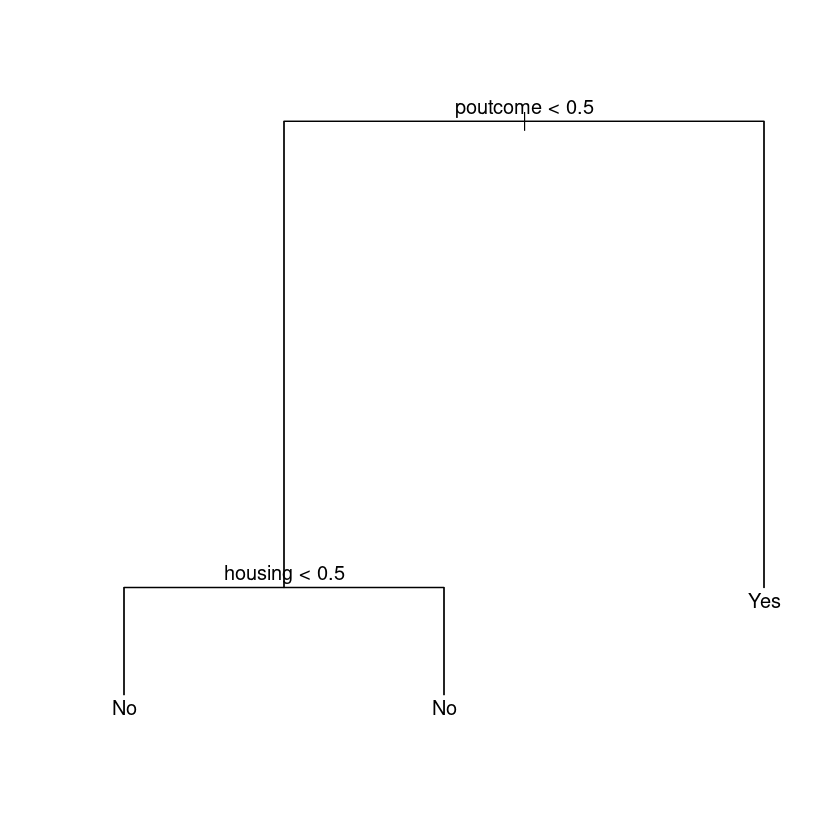

In [15]:
plot(treesub)
text(treesub, pretty = 0)

The decision tree has identified poutcome and housing as the only significant variables in predicting subscription, and, with both values of housing leading to "no", implies that poutcome is the only variable it can use to predict subscription. 

In [16]:
sub.pred <- predict(treesub, banktest, type = "class")
test.tab <- table(banktest$subscribed, sub.pred)
test.tab
test.tab.error <- 1 - (test.tab[2,1] + test.tab[1,2]) / sum(test.tab)
print(paste("Misclassification Rate: ", test.tab.error))

   sub.pred
     Yes    No
  0   108 7893
  1   202  840

[1] "Misclassification Rate:  0.104832467101626"


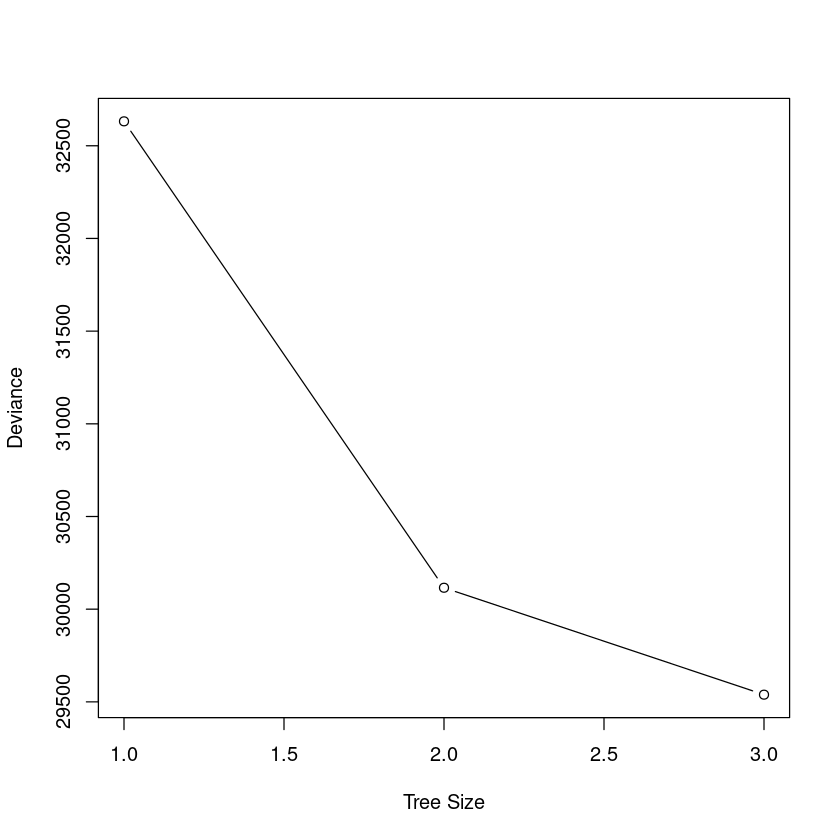

In [17]:
cv.sub = cv.tree(treesub, FUN = prune.tree)
plot(cv.sub$size, cv.sub$dev, type = "b", xlab = "Tree Size", ylab = "Deviance")

In [18]:
sub.pruned = prune.tree(treesub, best = cv.sub$size[which.min(cv.sub$dev)])
summary(sub.pruned)
summary(treesub)


Classification tree:
tree(formula = hassub ~ . - subscribed, data = bank)
Variables actually used in tree construction:
[1] "poutcome" "housing" 
Number of terminal nodes:  3 
Residual mean deviance:  0.6533 = 29540 / 45210 
Misclassification error rate: 0.1071 = 4844 / 45211 


Classification tree:
tree(formula = hassub ~ . - subscribed, data = bank)
Variables actually used in tree construction:
[1] "poutcome" "housing" 
Number of terminal nodes:  3 
Residual mean deviance:  0.6533 = 29540 / 45210 
Misclassification error rate: 0.1071 = 4844 / 45211 

Due to the tree having so few factors in use already, there is no improvement or decline in accuracy achieved in pruning it. Somewhat remarkably, with a misclassification error (as listed in the summary) of  10.71%, poutcome is instrumental in predicting whether or not a client subscribed to a term deposit.

### Results

In [19]:
print(paste("GLM Misclassification Rate: ", mean(glm.pred != banktest$subscribed)))
print(paste("LDA Misclassification Rate: ", mean (lda.class != banktest$subscribed)))
print(paste("QDA Misclassification Rate: ", mean (qda.class != banktest$subscribed)))
print(paste("Decision Tree Misclassification Rate: ", test.tab.error))

[1] "GLM Misclassification Rate:  0.105495963728851"
[1] "LDA Misclassification Rate:  0.105164215415238"
[1] "QDA Misclassification Rate:  0.108702864093774"
[1] "Decision Tree Misclassification Rate:  0.104832467101626"


All of the models performed fairly close to one another, with the Decision Tree performing the best and QDA performing the worst. With QDA performing over .35% worse than LDA, this suggests that any relationships between the feature variables in this model are more linear than quadratic. 

Interestingly, LDA had a misclassification rate of 10.516%, whereas the Decision Tree had one of 10.483%; the difference between the two is .033%, which is minute. The Decision Tree only chose three nodes of significance, which was unchanged when pruning the tree for minimal error. 

In analyzing the correlation table, as well as the first split of the decision tree, the most significant variable was poutcome (.31 correlation to subscribed); following that, it was housing (-.14 correlation to subscribed), then pdays (.1 correlation to subscribed); all other values had an absolute correlation value of less than .1. Based on the summary information of the decision tree, nearly 90% of all term deposits can be predicted based on the previous outcome of a marketing campaign.

### Conclusion



Using either a decision tree or linear discriminant analysis (LDA), and the feature variables related to outstanding loans and and marketing frequency, it is possible to determine whether or not a client will subscribed to a term deposit with nearly 90% accuracy. The most important determinant of a client subscribing to a term deposit is having done so previously. Surprisingly, having an outstanding loan (not including a housing loan) and the total balance of one's account have incredibly little influence on whether or not a client subscribes. 

An additional analysis, in which previous outcome becomes the target variable, may help to further understand what helps to drive clients to subscribe to term deposits. The near reliance on repeat clients is not an optimal strategy for sustainable growth, and discovering what may have lead to previous subscriptions would provide valuable insight into driving future subscriptions.